### Get subset of full dataset

First we import the necessary libraries

In [246]:
import csv
import pandas as pd
import random
import pyarrow.feather as feather
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time

We define a function to load a subset of the articles

In [247]:
#Indhenter et sample på ca. 1,45M artikler, meget tidseffektivt
def getSample(csvstring: str, sample_size: int):
    random.seed(0)
    n = 11000000 #number of records in file (excludes header)
    s = sample_size #desired sample size
    skip = sorted(random.sample(range(1,n+1),n-s))
    # Read the CSV file, skipping the randomly selected rows
    sampled_data = pd.read_csv(csvstring, on_bad_lines='skip', skiprows=skip, index_col=0)
    sampled_data = sampled_data.reset_index()
    return sampled_data

In [248]:
data = getSample("data/news_cleaned_2018_02_13-1.csv",50000)

In [249]:
len(data)

38701

### Inspecting The Sample

In [250]:
def get_type_freq(dataframe):
    typedict = {}
    for i in dataframe['type']: 
        if str(i) in typedict:
            typedict[str(i)] +=1 
        else: 
            typedict[str(i)] =1 
    typedict
    typedictperc = typedict.copy()
    #laver et nyt dictionairy som viser det i procenttal
    for i in typedictperc:
        typedictperc[i] = (typedictperc[i]/(len(data)))*100
    return typedictperc

In [251]:
get_type_freq(data)

{'satire': 1.3281310560450634,
 'hate': 1.0077258985555928,
 'conspiracy': 9.723262964781272,
 'junksci': 1.3978966951758354,
 'fake': 10.6457197488437,
 'clickbait': 2.6846851502545155,
 'political': 19.219141624247435,
 'bias': 13.371747500064599,
 'nan': 4.7027208599261,
 'unreliable': 3.5167049947029794,
 'unknown': 4.3874835275574275,
 'reliable': 22.39735407353815,
 'rumor': 5.61742590630733}

In [252]:
allArticlesCount = 928083 + 146080 + 1300444 + 905981 + 144939 + 117374 + 292201 + 2435471 + 319830 + 1920139
#Jeg henter data from README.md om hvor mange artikler af hver type, der er i det fulde datasæt
realtypeperc = {"reliable": (1920139/allArticlesCount)*100, "political": (2435471/allArticlesCount)*100, "bias": (1300444/allArticlesCount)*100, "Satire": (146080/allArticlesCount)*100, "fake": (928083/allArticlesCount)*100, "conspiracy":(905981/allArticlesCount)*100, "unreliable": (319830/allArticlesCount)*100, "clickbait":(292201/allArticlesCount)*100, "junksci":(144939/allArticlesCount)*100 , "hate":(117374/allArticlesCount)*100}
realtypeperc
#jeg præsenterer det som procenter
#ved sammenligning er det tydeligt, at Mikkels forkortede datasæt ikke har markant anderledes proportion ift. artikeltyper, end det fulde datasæt
#Største forskel er at der er tilføjet nye typer af artikler som rumor til datasættet, siden README blev skrevet. 
#Vi kan bruge dette til at forsikre os selv om at vores forkortede datasæt er repræsentativt for det fulde datasæt. 

{'reliable': 22.561888537768805,
 'political': 28.617108052577617,
 'bias': 15.280389897611691,
 'Satire': 1.716459421738357,
 'fake': 10.905098641191126,
 'conspiracy': 10.645397202669349,
 'unreliable': 3.7580450222794273,
 'clickbait': 3.4334005989277774,
 'junksci': 1.703052520039264,
 'hate': 1.3791601051965903}

### Structure Sample For Preprocessing

Before we preprocess there are some articles we can remove from the data set. We also change the labels so that
they are either 'reliable' or 'fake'

In [253]:
#Klassificerer alt som reliable/fake
def binary_labels(df): 
    #klassificerer alle de artikler vi vil bruge ind i reliable eller fake
    df.type = df.type.replace({'political': 'reliable', 'junksci': 'fake', 'bias' : 'fake', 'satire': 'fake', 'conspiracy': 'fake', 'rumor': 'fake', 'unreliable' : 'fake', 'clickbait': 'fake', 'hate': 'fake'})
    return df

In [254]:
data = binary_labels(data)

In [255]:
#Fjerner alle de artikler vi ikke skal bruges. NB: SKAL kaldes på en dataframe, som allerede har været igennem binary_labels
def remove_bad_articles(df): 
    #fjerner artikler som har volapyk types (inklusiv 'unknown')
    df = df[(df.type == 'reliable') |(df.type == 'fake')]
    #fjerner artikler som ikke har nogen type
    df = df[df.type.notnull()]
    #fjerner artikler uden content
    df = df[df.content.notnull()]
    #fjerner duplerede artikler, ud over en enkelt
    df = df.drop_duplicates(subset = 'content', keep = 'last')
    #fjerner de artikler som ikke indeholder mindst et latinsk bogstav
    df = df[df.content.str.contains('[a-z]')]
    #reset index gør, at hvis vi fjerner artikle [2], bliver artikel [3] rykket ned på index [2] osv. dernedad.
    df = df.reset_index().drop(columns='index').rename(columns={'level_0':'index'})
    return df 

In [256]:
data = remove_bad_articles(data)

In [257]:
data_length = len(data)

In [258]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [259]:
labelperc(data)

{'fake': 51.82145379932053, 'reliable': 48.17854620067947}

In [260]:
temp = "data/sample_structured.csv"

In [261]:
data.to_csv(temp, index=False)

In [262]:
# free memory
del data
gc.collect()

1848

### Preprocessing the larger sample

Then, we preprocess the sample

In [263]:
from datetime import datetime
from ipywidgets import IntProgress
from IPython.display import display
import cleaning_functions
import pandas as pd
import csv
import time
import itertools
import nltk

In [264]:
# RegEx patterns, catches expressions as var-names imply.
mail_pattern = re.compile(r"(?P<Mails>[w\.-]+@[\w\.-]+\.[\w]+)")
url_pattern = re.compile(r"(?P<URL>(?:(?:https?|ftp):[/][/])?[\w/\-?=%.]+\.[\w/\-&?=%.]+)")
date_pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
num_pattern = re.compile(r"[a-zA-Z]*\d+[a-zA-Z]*") 
#punct_remove = re.compile(r"[a-zA-Z]*[^a-zA-Z\s]+[a-zA-Z]*")
punct_remove = re.compile(r"[^a-zA-Z\s]+")
white_space = re.compile(r"[\s]+|\n+")


"""
Cleans the text from mail/url/date/whitespace/punctuation
"""
def clean_single_string(st):
    s1 = st.lower()
    s2 = mail_pattern.sub(" mail ", s1)
    s3 = url_pattern.sub(" url ", s2)
    s4 = date_pattern.sub(" date ", s3)
    s5 = num_pattern.sub(" num ", s4)
    s6 = punct_remove.sub(" ", s5)
    s7 = white_space.sub(" ", s6)
    return s7

# Call this function to clean the dataframe, BEFORE tokenizing.
#def clean_dataframe(dataframe):
    #start = time.time()
#    return dataframe['content'].apply(clean_single_string)
    #end = time.time()
    #print("cleaning took " + str(end - start) + " seconds")

In [265]:
def stopwords_remover():
    stop = stopwords.words('english')
    def remove_stopwords(tokenlist):
        return list(filter(lambda x : x not in stop, tokenlist))
    return remove_stopwords

In [266]:
def token_stemmer():
    stemmer = PorterStemmer()
    def stem_tokenlist(tokenlist):
        return [stemmer.stem(token) for token in tokenlist]
    return stem_tokenlist

In [267]:
def tokenizer():
    def tokenize(str):
        return nltk.word_tokenize(str)
    return tokenize

In [268]:
file_name = "data/sample_preprocessed_ver_" + datetime.today().strftime('%Y-%m-%d-%s') + ".csv"
meta_data = "meta_data/preprocess_info_" + datetime.today().strftime('%Y-%m-%d-%s') + "csv"

In [269]:
f = IntProgress(min=0, max=data_length)
display(f)
CHUNK_SIZE = 10000
for chunk in pd.read_csv(temp, chunksize=CHUNK_SIZE, index_col=0):
    #chunk = chunk[['type', 'content']]
    chunk['content'] = chunk['content'].apply(clean_single_string) # clean chunk
    chunk = remove_bad_articles(chunk)
    chunk = chunk[(chunk.type == 'reliable') |(chunk.type == 'fake')]
    #fjerner artikler som ikke har nogen type
    chunk = chunk[chunk.type.notnull()]
    #fjerner artikler uden content
    chunk = chunk[chunk.content.notnull()]
    chunk['content'] = chunk['content'].apply(tokenizer()) # tokenize    
    #vocab = set(itertools.chain.from_iterable(chunk['content'])) # get vocabulary
    chunk['content'] = chunk['content'].apply(stopwords_remover()) # remove stopwords
    #vocab_no_stopwords = set(itertools.chain.from_iterable(chunk['content'])) # get vocabulary
    chunk['content'] = chunk['content'].apply(token_stemmer()) # stem tokens
    #vocab_stemmed = set(itertools.chain.from_iterable(chunk['content'])) # get vocabulary
    chunk.to_csv(file_name, mode="a", index=False)

    #with open("data/content_test.csv", 'a') as file:
    #    writer = csv.writer(file)
    #    writer.writerows(chunk['content'])

    #chunk.to_csv("data/type_test.csv", mode="a", columns=['type'])

    #with open(meta_data,'a') as meta_data_file:
    #    writer = csv.writer(meta_data_file)
    #    writer.writerow([(len(vocab_no_stopwords) / len(vocab)),(len(vocab_no_stopwords) / len(vocab_stemmed))])

    f.value += CHUNK_SIZE


IntProgress(value=0, max=29729)

### Loading preprocessed dataset for model training


In [270]:
import pandas as pd
import regex as re
from cleantext import clean
import pyarrow.feather as feather
from multiprocessing import Pool
import gc
import nltk
from nltk.util import ngrams
from nltk.corpus import words
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *
import time
from collections import Counter
import seaborn as sns
from joblib import dump, load

from sklearn.model_selection import train_test_split    # splitting the data 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from ipywidgets import IntProgress
from IPython.display import display

In [271]:
data = pd.read_csv(file_name, index_col=0)

In [274]:
# convert the strings to lists
pattern = re.compile(r"\w+")
def string_to_list(s):
    return pattern.findall(s)

In [275]:
data['content'] = data['content'].apply(string_to_list)

In [276]:
def labelperc(df): 
    labeldict = {}
    for i in df.type: 
        if i in labeldict: 
            labeldict[i] +=1
        else: 
            labeldict[i] = 1
    for i in labeldict: 
        labeldict[i] = labeldict[i]/len(df)*100
    return labeldict

In [277]:
labelperc(data)

{'fake': 52.08658478659157, 'reliable': 47.91341521340843}

In [278]:
len(data)

29474

### Simple Model - Logistic Regression

In [279]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [280]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x : x, max_features=3000)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x2d5d4d090>, max_features=3000)

In [281]:
vectorizer.get_feature_names_out()

array(['abandon', 'abc', 'abil', ..., 'zero', 'zionist', 'zone'],
      dtype=object)

In [282]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [283]:
logreg = LogisticRegression(solver='sag')
logreg.fit(X_train, y_train)

/Users/mikkelkjaerulf/miniconda3/envs/fake_news/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [284]:
dump(logreg, "final_models/logreg.joblib")

['final_models/logreg.joblib']

In [285]:
pred = logreg.predict(X_val)

In [286]:
accuracy_score(y_val, pred)

0.7645062775704106

In [287]:
from sklearn.metrics import f1_score

# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7496392496392497

[[1214  286]
 [ 408 1039]]


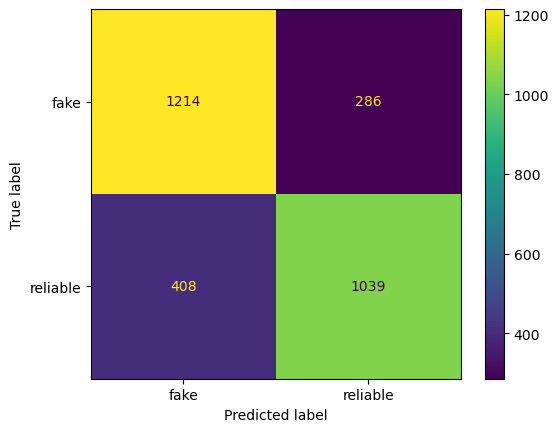

In [288]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred, labels=logreg.classes_)
print(cf_matrix)
# plotting to a heatmap
#sns.heatmap(cf_matrix, annot=True, fmt='g')
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=logreg.classes_).plot()

### Advanced Model - Naive Bayes

In [289]:
X_train, X_val, y_train, y_val = train_test_split(data['content'], data['type'], test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x : x, max_features=3000)
vectorizer.fit(X_train)

TfidfVectorizer(analyzer=<function <lambda> at 0x2cbd9c310>, max_features=3000)

In [291]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [292]:
vectorizer.get_feature_names_out()

array(['abandon', 'abc', 'abil', ..., 'zero', 'zionist', 'zone'],
      dtype=object)

In [293]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [294]:
dump(nb, "final_models/nb.joblib")

['final_models/nb.joblib']

In [295]:
pred = nb.predict(X_val)

In [296]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, pred)

0.7533084492704445

In [297]:
from sklearn.metrics import f1_score
# y_val er pandas series, så omdanner også til ndarray
# positive = reliable
f1_score(pd.Series.to_numpy(y_val), pred, pos_label='reliable')

0.7326222876057373

[[1224  276]
 [ 451  996]]


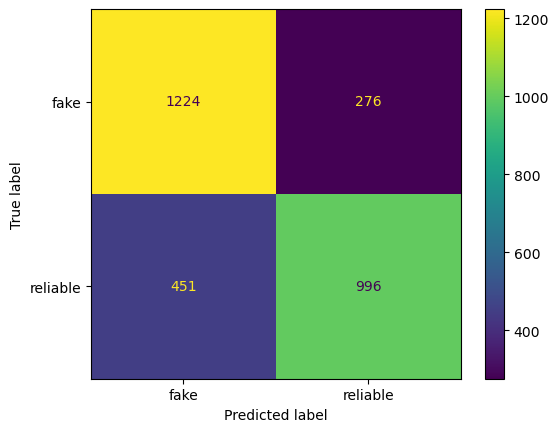

In [298]:
from sklearn.metrics import confusion_matrix
# generating confusion matrix
cf_matrix = confusion_matrix(pd.Series.to_numpy(y_val), pred)
print(cf_matrix)
# plotting to a heatmap
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=nb.classes_).plot()